In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


In [2]:
from tensorflow.keras.applications import ResNet152, InceptionV3, InceptionResNetV2

In [3]:
inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape = (299, 299, 3)
)

for layer in inceptionV3.layers:
    layer.trainable = True

In [4]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
inceptionV3_resnet152 = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=((299, 299, 3))
)

for layer in inceptionV3_resnet152.layers:
    layer.trainable = True

In [6]:
inceptionV3_resnet152.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
________________________________________________________________________________

In [7]:
resnet152 = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape=((224, 224, 3))
)

for layer in resnet152.layers:
    layer.trainable = True

reshaping = layers.Reshape((8, 8, 1568))(resnet152.output)
re_config_resnet152 = tensorflow.keras.Model(inputs=resnet152.input, outputs=reshaping)

In [8]:
a = np.zeros(shape=(7, 7, 2048))
a = a.reshape(8, 8, 1568)
a.shape

(8, 8, 1568)

In [9]:
re_config_resnet152.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [2]:

# sort losses of batch descending order
# the largest k? is averaged as the final loss
# return loss
# parameters needed: SUM, label(i), loss of batches


def ohem_loss(ytrue, ypred):
    result = K.categorical_crossentropy(ytrue, ypred, axis=-1)
    alpha = K.variable(0.1, dtype=tf.float32)
    index = K.greater(result, alpha)
    cast = tf.cast(index, tf.float32)
    return result*cast

In [10]:
from tensorflow.keras import Model
from tensorflow.keras import backend as K


concat_feature_layer = layers.concatenate([inceptionV3.output, inceptionV3_resnet152.output, re_config_resnet152.output])
fully_connected_dense_big = layers.Dense(1024, activation='relu')(concat_feature_layer)
dropout_one = layers.Dropout(0.5)(fully_connected_dense_big)
flatten_layer = layers.Flatten()(dropout_one)
fully_connected_dense_small = layers.Dense(512, activation='relu')(flatten_layer)
dropout_two = layers.Dropout(0.5)(fully_connected_dense_small)
fully_connected_dense_class = layers.Dense(4, activation='softmax')(dropout_two)

model = Model(
    inputs=[inceptionV3.input, inceptionV3_resnet152.input, re_config_resnet152.input],
    outputs=fully_connected_dense_class
)

model.compile(
    loss=ohem_loss,
    optimizer='adam'
)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [11]:
modelplot = tensorflow.keras.utils.plot_model(model)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.583832 to fit



In [12]:
print(os.getcwd())
path_to_chb_01 = "Dataset/win_chb_01"

/Users/niklashjort/Desktop/Notes/Speciale/projects


In [13]:
resnet152_input_shape = (224, 224)
inceptionV3_input_shape = (299, 299)

In [14]:
labels = [item for item in os.listdir(path_to_chb_01)]
labels = np.array(labels)
labels = labels[0:]
print(labels.shape)
labels

(4,)


array(['Preictal_One', 'Preictal_Two', 'Seizure', 'Interictal'],
      dtype='<U12')

In [15]:
batch_data_generator_one = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

batch_data_generator_two = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

batch_data_generator_three = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)


inceptionV3_train_set = batch_data_generator_one.flow_from_directory(
path_to_chb_01,
target_size=inceptionV3_input_shape,
color_mode='rgb',
batch_size=100,
class_mode='categorical',
shuffle=False,
subset='training',
classes = list(labels)
)

inceptionV3_validation_set = batch_data_generator_one.flow_from_directory(
path_to_chb_01,
target_size=inceptionV3_input_shape,
color_mode='rgb',
batch_size=100,
class_mode='categorical',
shuffle=False,
subset='validation',
classes = list(labels)
)

inceptionV3_resnet_train_set = batch_data_generator_two.flow_from_directory(
path_to_chb_01,
target_size=inceptionV3_input_shape,
color_mode='rgb',
batch_size=100,
class_mode='categorical',
shuffle=False,
subset='training',
classes = list(labels)
)

inceptionV3_resnet_validation_set = batch_data_generator_two.flow_from_directory(
path_to_chb_01,
target_size=inceptionV3_input_shape,
color_mode='rgb',
batch_size=100,
class_mode='categorical',
shuffle=False,
subset='validation',
classes = list(labels)
)

resnet_train_set = batch_data_generator_three.flow_from_directory(
path_to_chb_01,
target_size=resnet152_input_shape,
color_mode='rgb',
batch_size=100,
class_mode='categorical',
shuffle=False,
subset='training',
classes = list(labels)
)

resnet_validation_set = batch_data_generator_three.flow_from_directory(
path_to_chb_01,
target_size=resnet152_input_shape,
color_mode='rgb',
batch_size=100,
class_mode='categorical',
shuffle=False,
subset='validation',
classes = list(labels)
) 

def create_data_generator(incepV3_gen, incepV3_resnet_gen, resnet_gen):

    while(True):
        _gen1, _gen1_l = next(incepV3_gen)
        _gen2, _gen2_l = next(incepV3_resnet_gen)
        _gen3, _gen3_l = next(resnet_gen)

        yield [_gen1, _gen2, _gen3], [_gen1_l, _gen2_l, _gen3_l]

multi_train_generator = create_data_generator(
    inceptionV3_train_set, 
    inceptionV3_resnet_train_set, 
    resnet_train_set
    )

multi_validation_generator = create_data_generator(
    inceptionV3_validation_set, 
    inceptionV3_resnet_validation_set,
    resnet_validation_set
    )

Found 5818 images belonging to 4 classes.
Found 1454 images belonging to 4 classes.
Found 5818 images belonging to 4 classes.
Found 1454 images belonging to 4 classes.
Found 5818 images belonging to 4 classes.
Found 1454 images belonging to 4 classes.


In [16]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(15):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title(labels[label[n].argmax()])
      plt.axis('off')

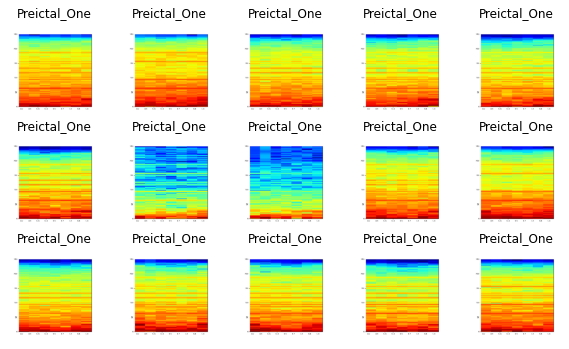

In [17]:
image, label = next(inceptionV3_train_set)
show_batch(image, label)

In [18]:
class TestCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x = self.test_data
        loss, acc = self.model.evaluate(x, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [21]:
history = model.fit(
    x=multi_train_generator,
    epochs=3,
    batch_size=100,
    steps_per_epoch = inceptionV3_train_set.samples//100,
    validation_data=multi_validation_generator, 
    validation_steps = inceptionV3_validation_set.samples//100,
    callbacks=[TestCallback((multi_validation_generator))] 
)

Epoch 1/3
 2/58 [>.............................] - ETA: 2:40:01 - loss: 1.3115